In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [2]:
import sys
sys.path.append('/data3/Astro/global/python/')
from cal_well_data import cal_prod_rate, cal_inj_bhp

In [3]:
# data_dir = '/data3/Astro/lstm_rom/e2c_larry/data/9w_bhp_rate_fix_wl/'
data_dir = '/data3/Astro/lstm_rom/e2c_larry/data/9w_ms_bhp_rate_fix_wl/'

case_name = '9w_ms_bhp_rate'

target_suffix = '_fix_wl_rel_8' # the dataset being evaluated here
train_suffix = '_with_p'
model_suffix = '_flux_loss'

num_t = 20
run_eval = 100
num_eval = num_t * run_eval
# dt = 200 // num_t
dt = 100 # days

nt = 6000

In [4]:
# well_loc_file = '/data/cees/zjin/lstm_rom/sim_runs/case6_9w_bhp_rate_ms_h5/template/well_loc00.dat'
well_loc_file = '/data3/Astro/personal/zjin/sim_runs/case8_9w_bhp_rate_ms_gau/template/well_loc00.dat'

In [5]:
hf_r = h5py.File(data_dir + case_name + target_suffix + '_nt_%d_state_seq_pred_ctrl.mat'%(nt), 'r')
state_true = np.array(hf_r.get('true_seq'))
state_pred = np.array(hf_r.get('pred_seq'))
state_train = np.array(hf_r.get('train_seq'))
ctrl = np.array(np.array(hf_r.get('ctrl_seq')))
train_ctrl = np.array(hf_r.get('train_ctrl'))
eval_ctrl = np.array(hf_r.get('eval_ctrl'))
hf_r.close()

In [6]:
print(ctrl.shape)
print(state_true.shape)
print(state_pred.shape)
print(state_train.shape)
print(train_ctrl.shape)
print(eval_ctrl.shape)

(100, 20, 18)
(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(300, 180)
(100, 180)


In [7]:
well_loc = np.loadtxt(well_loc_file).astype(int)
num_prod = well_loc[0,0]
num_inj = well_loc[0,1]
num_well = num_prod+num_inj
print(num_inj, num_prod)

4 5


In [8]:
prod_loc = well_loc[1:num_prod+1,:]
print("prod_loc:\n{}".format(prod_loc))
inj_loc = well_loc[num_prod+1:,:]
print("inj_loc:\n{}".format(inj_loc))

prod_loc:
[[10 10]
 [ 8 52]
 [30 30]
 [50 10]
 [50 50]]
inj_loc:
[[ 7 23]
 [35 10]
 [18 40]
 [50 36]]


## Find closest training

In [9]:
print(state_true.shape)
print(state_pred.shape)
print(state_train.shape)
print(ctrl.shape)
print(train_ctrl.shape)
print(eval_ctrl.shape)

num_train = state_train.shape[0]
num_eval = state_true.shape[0]
print("num_train:{}".format(num_train))
print("num_eval:{}".format(num_eval))

(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(100, 20, 18)
(300, 180)
(100, 180)
num_train:300
num_eval:100


In [10]:
ctrl_dist = np.zeros((num_eval, num_train))
for i in range(num_eval):
    ctrl_dist[i,:] = np.linalg.norm(eval_ctrl[i,:] - train_ctrl, axis=1, ord=1)
print(ctrl_dist.shape)

(100, 300)


In [11]:
close_train = np.argmax(ctrl_dist, axis=1)
print(close_train.shape)

(100,)


In [12]:
min_ctrl_dist = np.zeros((num_eval))
for i in range(num_eval):
    min_ctrl_dist[i] = ctrl_dist[i, close_train[i]]
print(min_ctrl_dist.shape)

(100,)


In [13]:
# num_case = len(ind_case)
num_step = state_true.shape[1]
# print("num_case:%d"%(num_case))
print("num_step:%d"%(num_step))

num_step:20


In [14]:
p_max = 425*14.5038
p_min = 250*14.5038

p_diff = p_max - p_min
p_mid = 0.45*p_diff + p_min
print(p_mid)

q_max = 6500
q_min = 1500
q_diff = q_max - q_min

4768.12425


In [15]:
state_pred[:, :, :, :, 1] = state_pred[:, :, :, :, 1] * p_diff + p_min
state_true[:, :, :, 1] = state_true[:, :, :, 1] * p_diff + p_min
state_train[:, :, :, 1] = state_train[:, :, :, 1] * p_diff + p_min

In [16]:
# logk_file = '/data/cees/zjin/lstm_rom/sim_runs/case4_9w_bhp_rate/template/logk1.dat'
logk_file = '/data3/Astro/personal/zjin/sim_runs/case8_9w_bhp_rate_ms_gau/template/logk1.dat'
logk = np.loadtxt(logk_file)
# logk = logk.reshape((60,60)).T

In [17]:
# this shold be correct
# i: index on x-axis
# j: index on y-axis
def get_logk(logk, i, j):
    nx = 60
    ny = 60
    return logk[j*nx + i] -3.5

In [18]:
t_steps = np.arange(0,200,10)

In [19]:
print(t_steps)
num_tstep = len(t_steps)
print(num_tstep)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
20


## Err. analysis oil/water production rates

In [20]:
### Calculate oil/water production rates
###
bbl2m3 = 6.2898 * 1000
wrat_true        = np.zeros((num_eval, num_step, num_prod))
wrat_pred        = np.zeros((num_eval, num_step, num_prod))
wrat_close_train = np.zeros((num_eval, num_step, num_prod))
orat_true        = np.zeros((num_eval, num_step, num_prod))
orat_pred        = np.zeros((num_eval, num_step, num_prod))
orat_close_train = np.zeros((num_eval, num_step, num_prod))

for k in range(run_eval):
    for i in range(num_prod):
        prodx = prod_loc[i, 0]
        prody = prod_loc[i, 1]
        perm = np.exp(get_logk(logk, prodx, prody))
        sat_true = state_true[k, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_pred = state_pred[k, :, :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        sat_close_train = state_train[close_train[k], :, :,0].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        pres_true = state_true[k, :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_pred = state_pred[k, :, :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        pres_close_train = state_train[close_train[k], :, :,1].reshape((num_step, 60, 60))[:, prod_loc[i,1], prod_loc[i, 0]]
        
        
        bhp = ctrl[k, :, i+num_well] * p_diff + p_min

        for j in range(len(bhp)):
            wrat_true[k,j,i], orat_true[k,j,i] = cal_prod_rate(pres_true[[j]], sat_true[[j]], bhp[j], perm)
            wrat_pred[k,j,i], orat_pred[k,j,i] = cal_prod_rate(pres_pred[[j]], sat_pred[[j]], bhp[j], perm)
            wrat_close_train[k,j,i], orat_close_train[k,j,i] = cal_prod_rate(pres_close_train[[j]], sat_close_train[[j]], bhp[j], perm)

wrat_true        /= bbl2m3
wrat_pred        /= bbl2m3
wrat_close_train /= bbl2m3
orat_true        /= bbl2m3
orat_pred        /= bbl2m3
orat_close_train /= bbl2m3

In [21]:
print(wrat_true.shape)
print(wrat_pred.shape)
print(wrat_close_train.shape)
print(orat_true.shape)
print(orat_pred.shape)
print(orat_close_train.shape)

(100, 20, 5)
(100, 20, 5)
(100, 20, 5)
(100, 20, 5)
(100, 20, 5)
(100, 20, 5)


In [22]:
rates_true = np.concatenate((wrat_true[...,np.newaxis], orat_true[...,np.newaxis]),axis=3)
rates_pred = np.concatenate((wrat_pred[...,np.newaxis], orat_pred[...,np.newaxis]),axis=3)
rates_close_train = np.concatenate((wrat_close_train[...,np.newaxis], orat_close_train[...,np.newaxis]),axis=3)
print(rates_true.shape)
print(rates_pred.shape)
print(rates_close_train.shape)

(100, 20, 5, 2)
(100, 20, 5, 2)
(100, 20, 5, 2)


In [23]:
epsilon = 1e-3
rates_diff_true_pred = np.fabs(rates_true - rates_pred)
rates_diff_true_close_train = np.fabs(rates_true - rates_close_train)
rates_true_abs = np.fabs(rates_true)

print(rates_diff_true_pred.shape)
print(rates_diff_true_close_train.shape)
print(rates_true_abs.shape)

rates_rel_err_true_pred_per_well = np.sum(np.sum(rates_diff_true_pred, axis=1) / (np.sum(rates_true_abs, axis=1) + epsilon), axis=2)
rates_rel_err_true_close_train_per_well = np.sum(np.sum(rates_diff_true_close_train, axis=1) / (np.sum(rates_true_abs, axis=1) + epsilon), axis=2)
# rates_rel_err_true_pred_per_well = np.sum(rates_diff_true_pred, axis=(1,3)) / (np.sum(rates_true_abs, axis=(1,3)) + epsilon)
# rates_rel_err_true_close_train_per_well = np.sum(rates_diff_true_close_train, axis=(1,3)) / (np.sum(rates_true_abs, axis=(1,3)) + epsilon)

print(rates_rel_err_true_pred_per_well.shape)
print(rates_rel_err_true_close_train_per_well.shape)

rates_rel_err_true_pred = np.mean(rates_rel_err_true_pred_per_well, axis=1)
rates_rel_err_true_close_train = np.mean(rates_rel_err_true_close_train_per_well, axis=1)
print(rates_rel_err_true_pred.shape)
print(rates_rel_err_true_close_train.shape)

(100, 20, 5, 2)
(100, 20, 5, 2)
(100, 20, 5, 2)
(100, 5)
(100, 5)
(100,)
(100,)


In [24]:
plt.rcParams.update({'font.size': 22})

In [25]:
print(nt)

6000


In [26]:
print(np.mean(rates_rel_err_true_pred))

0.16359699060765995


In [27]:
sort_idx_tr_err = np.argsort(rates_rel_err_true_close_train)
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)

i1, = np.where(sort_idx_tr_err == 25)
print(i1)

i2, = np.where(sort_idx_tr_err == 77)
print(i2)

i3, = np.where(sort_idx_tr_err == 97)
print(i3)

print(sort_idx_tr_err[24])
print(sort_idx_tr_err[49])
print(sort_idx_tr_err[74])

[24]
[74]
[49]
25
97
77


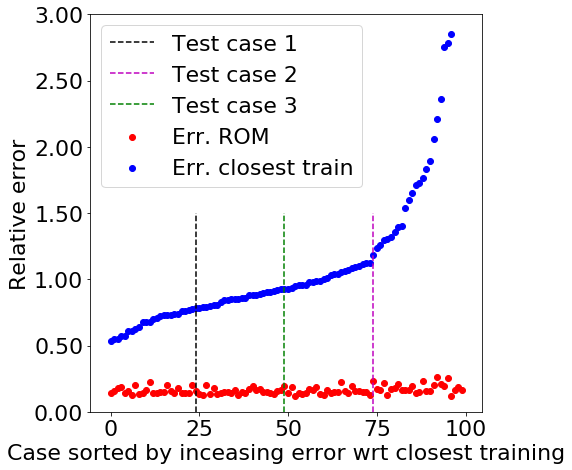

In [28]:
from matplotlib.ticker import FormatStrFormatter
# plt.figure(figsize=(8,7))
fig1, ax1 = plt.subplots()
fig1.set_figheight(7)
fig1.set_figwidth(8)
# plt.subplot(121)
plt.scatter(np.arange(100), rates_rel_err_true_pred[sort_idx_tr_err], c='r')
plt.scatter(np.arange(100), rates_rel_err_true_close_train[sort_idx_tr_err], c='b')

plt.plot(np.ones((2,))*i1, np.array([0,1.5]), 'k--')
plt.plot(np.ones((2,))*i2, np.array([0,1.5]), 'm--')
plt.plot(np.ones((2,))*i3, np.array([0,1.5]), 'g--')
plt.ylabel('Relative error')
plt.xlabel('Case sorted by inceasing error wrt closest training')
plt.legend(['Test case 1', 'Test case 2', 'Test case 3', 'Err. ROM', 'Err. closest train'])
plt.ylim([0, 3])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()
plt.savefig('figs/'+ 'rel_err_rates_' + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps', pad_inches=0.1)
plt.savefig('figs/'+ 'rel_err_rates_' + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf', pad_inches=0.1)

# plt.subplot(122)
# plt.scatter(np.arange(100), rates_rel_err_true_pred[sort_idx_ctrl_dist], c='r')
# plt.scatter(np.arange(100), rates_rel_err_true_close_train[sort_idx_ctrl_dist], c='b')
# plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
# plt.ylabel('Relative error')
# plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 3])

In [29]:
print(rates_true.shape)
print(rates_pred.shape)

(100, 20, 5, 2)
(100, 20, 5, 2)


(100,)
(100,)
(100,)
(100,)


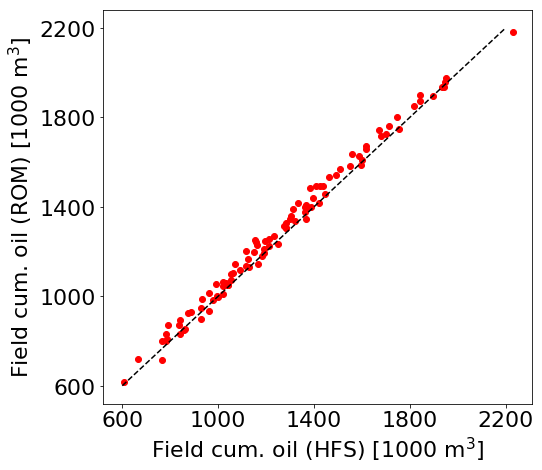

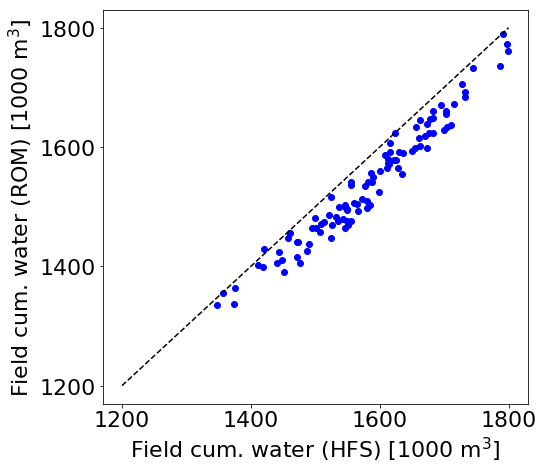

In [30]:
cum_oil_true = np.sum(rates_true[:,:,:,0], axis=(1,2)) * dt
cum_water_true = np.sum(rates_true[:,:,:,1], axis=(1,2)) * dt
cum_oil_pred = np.sum(rates_pred[:,:,:,0], axis=(1,2)) * dt
cum_water_pred = np.sum(rates_pred[:,:,:,1], axis=(1,2)) * dt

print(cum_oil_true.shape)
print(cum_water_true.shape)
print(cum_oil_pred.shape)
print(cum_water_pred.shape)

plt.figure(figsize=(8,7))
plt.scatter(cum_oil_true, cum_oil_pred, c='r')
plt.plot(np.arange(600, 2201,100), np.arange(600, 2201,100), 'k--')
plt.ylabel(r'Field cum. oil (ROM) [1000 m$^3$]')
plt.xlabel(r'Field cum. oil (HFS) [1000 m$^3$]')
plt.xticks(np.arange(600, 2201, 400))
plt.yticks(np.arange(600, 2201, 400))
plt.tight_layout()
plt.savefig('figs/'+ 'cum_oil_' + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps', pad_inches=0.1)
plt.savefig('figs/'+ 'cum_oil_' + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf', pad_inches=0.1)


plt.figure(figsize=(8,7))
plt.scatter(cum_water_true, cum_water_pred, c='b')
plt.plot(np.arange(1200, 1801,100), np.arange(1200, 1801,100), 'k--')
plt.ylabel(r'Field cum. water (ROM) [1000 m$^3$]')
plt.xlabel(r'Field cum. water (HFS) [1000 m$^3$]')
plt.xticks(np.arange(1200, 1801, 200))
plt.yticks(np.arange(1200, 1801, 200))
plt.tight_layout()
plt.savefig('figs/'+ 'cum_water_' + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps', pad_inches=0.1)
plt.savefig('figs/'+ 'cum_water_' + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf', pad_inches=0.1)

## Err. analysis injection BHP

In [31]:
print(num_eval)

100


In [32]:
inj_bhp_pred        = np.zeros((num_eval, num_step, num_inj))
inj_bhp_true        = np.zeros((num_eval, num_step, num_inj))
inj_bhp_close_train = np.zeros((num_eval, num_step, num_inj))

for k in range(num_eval):
    for i in range(num_inj):
        injx = inj_loc[i, 0]
        injy = inj_loc[i, 1]
        perm = np.exp(get_logk(logk, injx, injy))
        sat_true = state_true[k, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_pred = state_pred[k, :, :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        sat_train = state_train[close_train[k], :, :,0].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        pres_true = state_true[k, :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_pred = state_pred[k, :, :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        pres_train = state_train[close_train[k], :, :,1].reshape((num_step, 60, 60))[:, inj_loc[i,1], inj_loc[i, 0]]
        
        inj_rate = ctrl[k, :, i+num_prod+num_well] * q_diff + q_min
        
        for j in range(len(bhp)):
            inj_bhp_pred[k,j,i] = cal_inj_bhp(pres_pred[[j]], sat_pred[[j]], inj_rate[j], perm)
            inj_bhp_true[k,j,i] = cal_inj_bhp(pres_true[[j]], sat_true[[j]], inj_rate[j], perm)
            inj_bhp_close_train[k,j,i] = cal_inj_bhp(pres_train[[j]], sat_train[[j]], inj_rate[j], perm)
        

In [33]:
print(inj_bhp_pred.shape)
print(inj_bhp_true.shape)
print(inj_bhp_close_train.shape)

(100, 20, 4)
(100, 20, 4)
(100, 20, 4)


In [34]:
epsilon = 1e-3
inj_bhp_diff_true_pred = np.fabs(inj_bhp_true - inj_bhp_pred)
inj_bhp_diff_true_close_train = np.fabs(inj_bhp_true - inj_bhp_close_train)
inj_bhp_true_abs = np.fabs(inj_bhp_true)

print(inj_bhp_diff_true_pred.shape)
print(inj_bhp_diff_true_close_train.shape)
print(inj_bhp_true_abs.shape)

inj_bhp_rel_err_true_pred_per_well = np.sum(inj_bhp_diff_true_pred, axis=1) / (np.sum(inj_bhp_true_abs, axis=1) + epsilon)
inj_bhp_rel_err_true_close_train_per_well = np.sum(inj_bhp_diff_true_close_train, axis=1) / (np.sum(inj_bhp_true_abs, axis=1) + epsilon)

print(inj_bhp_rel_err_true_pred_per_well.shape)
print(inj_bhp_rel_err_true_close_train_per_well.shape)

inj_bhp_rel_err_true_pred = np.mean(inj_bhp_rel_err_true_pred_per_well, axis=1)
inj_bhp_rel_err_true_close_train = np.mean(inj_bhp_rel_err_true_close_train_per_well, axis=1)
print(inj_bhp_rel_err_true_pred.shape)
print(inj_bhp_rel_err_true_close_train.shape)

(100, 20, 4)
(100, 20, 4)
(100, 20, 4)
(100, 4)
(100, 4)
(100,)
(100,)


In [35]:
print(np.mean(inj_bhp_rel_err_true_pred))

0.00872944648438704


In [36]:
sort_idx_tr_err = np.argsort(inj_bhp_rel_err_true_close_train)
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)
i1, = np.where(sort_idx_tr_err == 25)
print(i1)

i2, = np.where(sort_idx_tr_err == 97)
print(i2)

i3, = np.where(sort_idx_tr_err == 77)
print(i3)

print(sort_idx_tr_err[24]) # 1st quantile
print(sort_idx_tr_err[49]) # 2nd quantile
print(sort_idx_tr_err[74]) # 3rd quantile

[79]
[9]
[64]
15
49
17


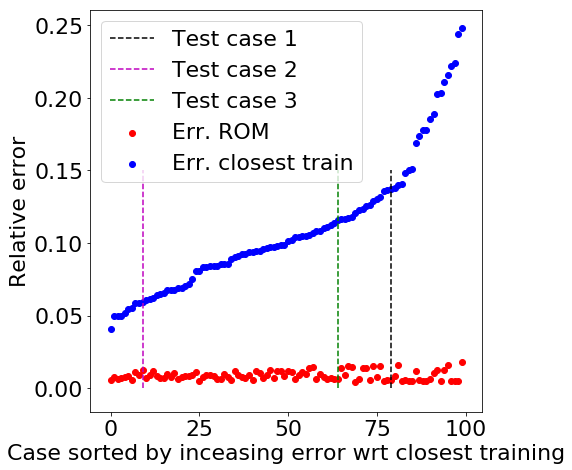

In [37]:
from matplotlib.ticker import FormatStrFormatter
# plt.figure(figsize=(8,7))
fig1, ax1 = plt.subplots()
fig1.set_figheight(7)
fig1.set_figwidth(8)
# plt.subplot(121)
plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_pred[sort_idx_tr_err], c='r')
plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_close_train[sort_idx_tr_err], c='b')

plt.plot(np.ones((2,))*i1, np.array([0,.15]), 'k--')
plt.plot(np.ones((2,))*i2, np.array([0,.15]), 'm--')
plt.plot(np.ones((2,))*i3, np.array([0,.15]), 'g--')

plt.ylabel('Relative error')
plt.xlabel('Case sorted by inceasing error wrt closest training')
plt.legend(['Test case 1', 'Test case 2', 'Test case 3', 'Err. ROM', 'Err. closest train'])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.ylim([0, 2])
plt.tight_layout()

# plt.subplot(122)
# plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_pred[sort_idx_ctrl_dist], c='r')
# plt.scatter(np.arange(num_eval), inj_bhp_rel_err_true_close_train[sort_idx_ctrl_dist], c='b')
# plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
# plt.ylabel('Relative error')
# plt.legend(['Err. pred', 'Err. closest training'])
# plt.ylim([0, 2])
plt.savefig('figs/'+ 'rel_err_inj_bhp_' + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps', pad_inches=0.1)
plt.savefig('figs/'+ 'rel_err_inj_bhp_' + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf', pad_inches=0.1)

## Err. Analysis Pres/Sat

In [38]:
print(state_true.shape)
print(state_pred.shape)
print(state_train.shape)
print(close_train.shape)

(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(100,)


In [39]:
state_pred_0 = state_pred.reshape(num_eval, num_step, 3600, 2)
print(state_pred_0.shape)
state_close_train = state_train[close_train, ...]
print(state_close_train.shape)

(100, 20, 3600, 2)
(100, 20, 3600, 2)


In [40]:
epsilon = 1e-3
state_diff_true_pred = np.fabs(state_true - state_pred_0)
state_diff_true_close_train = np.fabs(state_true - state_close_train)
state_true_abs = np.fabs(state_true)

print(state_diff_true_pred.shape)
print(state_diff_true_close_train.shape)
print(state_true_abs.shape)

(100, 20, 3600, 2)
(100, 20, 3600, 2)
(100, 20, 3600, 2)


In [41]:
state_rel_err_true_pred = np.sum(state_diff_true_pred, axis=(1,2)) / (np.sum(state_true_abs, axis=(1,2)) + epsilon)
state_rel_err_true_close_train = np.sum(state_diff_true_close_train, axis=(1,2)) / (np.sum(state_true_abs, axis=(1,2)) + epsilon)

print(state_rel_err_true_pred.shape)
print(state_rel_err_true_close_train.shape)

(100, 2)
(100, 2)


In [42]:
print(np.mean(state_rel_err_true_pred[:,0]))

0.039477407341711006


In [43]:
sort_idx_tr_err = np.argsort(state_rel_err_true_close_train[:,0])
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)
print(sort_idx_tr_err.shape)

i1, = np.where(sort_idx_tr_err == 25)
print(i1)

i2, = np.where(sort_idx_tr_err == 97)
print(i2)

i3, = np.where(sort_idx_tr_err == 77)
print(i3)

print(sort_idx_tr_err[24]) # 1st quantile
print(sort_idx_tr_err[49]) # 2nd quantile
print(sort_idx_tr_err[74]) # 3rd quantile

(100,)
[36]
[83]
[99]
36
7
82


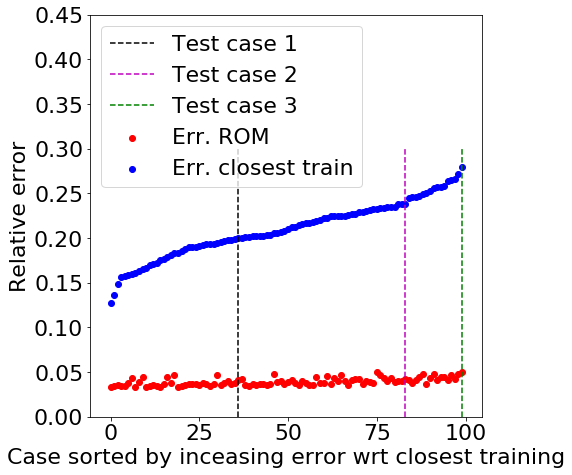

In [44]:
from matplotlib.ticker import FormatStrFormatter
# plt.figure(figsize=(8,7))
fig1, ax1 = plt.subplots()
fig1.set_figheight(7)
fig1.set_figwidth(8)
# plt.subplot(121)
plt.scatter(np.arange(num_eval), state_rel_err_true_pred[sort_idx_tr_err, 0], c='r')
plt.scatter(np.arange(num_eval), state_rel_err_true_close_train[sort_idx_tr_err, 0], c='b')

plt.plot(np.ones((2,))*i1, np.array([0,.3]), 'k--')
plt.plot(np.ones((2,))*i2, np.array([0,.3]), 'm--')
plt.plot(np.ones((2,))*i3, np.array([0,.3]), 'g--')

plt.ylabel('Relative error')
plt.xlabel('Case sorted by inceasing error wrt closest training')
plt.legend(['Test case 1', 'Test case 2', 'Test case 3', 'Err. ROM', 'Err. closest train'])
plt.ylim([0, .45])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()

# plt.subplot(122)
# plt.scatter(np.arange(num_eval), state_rel_err_true_pred[sort_idx_ctrl_dist, 0], c='r')
# plt.scatter(np.arange(num_eval), state_rel_err_true_close_train[sort_idx_ctrl_dist, 0], c='b')
# plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
# plt.ylabel('Relative error')
# plt.legend(['Err. pred', 'Err. closest training'])
# # plt.ylim([0, 2])

plt.savefig('figs/'+ 'rel_err_sat_' + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps', pad_inches=0.1)
plt.savefig('figs/'+ 'rel_err_sat_' + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf', pad_inches=0.1)

In [45]:
# sort_idx_pr_err = np.argsort(state_rel_err_true_pred[:,0])
# print(sort_idx_pr_err[-5:])
# a = state_rel_err_true_pred
# b = state_rel_err_true_close_train
# a[sort_idx_pr_err[-5:]] = None
# b[sort_idx_pr_err[-5:]] = None
# # print(a)

# plt.figure(figsize=(15,6))
# plt.subplot(121)
# plt.scatter(np.arange(num_eval), a[sort_idx_tr_err, 0], c='r')
# plt.scatter(np.arange(num_eval), b[sort_idx_tr_err, 0], c='b')
# plt.ylabel('Relative error')
# plt.xlabel('Case num. sorted by inceasing err wrt closest training')
# plt.legend(['Err. pred', 'Err. closest training'])
# # plt.ylim([0, 2])

# plt.subplot(122)
# plt.scatter(np.arange(num_eval), a[sort_idx_ctrl_dist, 0], c='r')
# plt.scatter(np.arange(num_eval), b[sort_idx_ctrl_dist, 0], c='b')
# plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
# plt.ylabel('Relative error')
# plt.legend(['Err. pred', 'Err. closest training'])

In [46]:
print(np.mean(state_rel_err_true_pred[:,1]))

0.002149047496872297


In [47]:
sort_idx_tr_err = np.argsort(state_rel_err_true_close_train[:,1])
sort_idx_ctrl_dist = np.argsort(min_ctrl_dist)
print(sort_idx_tr_err.shape)

i1, = np.where(sort_idx_tr_err == 25)
print(i1)

i2, = np.where(sort_idx_tr_err == 97)
print(i2)

i3, = np.where(sort_idx_tr_err == 77)
print(i3)

print(sort_idx_tr_err[24]) # 1st quantile
print(sort_idx_tr_err[49]) # 2nd quantile
print(sort_idx_tr_err[74]) # 3rd quantile

(100,)
[76]
[14]
[45]
63
5
30


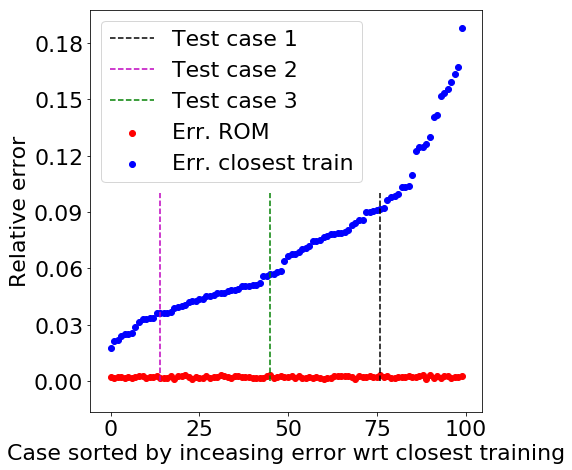

In [48]:
from matplotlib.ticker import FormatStrFormatter
# plt.figure(figsize=(8,7))
fig1, ax1 = plt.subplots()
fig1.set_figheight(7)
fig1.set_figwidth(8)
# plt.subplot(121)
plt.scatter(np.arange(num_eval), state_rel_err_true_pred[sort_idx_tr_err, 1], c='r')
plt.scatter(np.arange(num_eval), state_rel_err_true_close_train[sort_idx_tr_err, 1], c='b')

plt.plot(np.ones((2,))*i1, np.array([0,.1]), 'k--')
plt.plot(np.ones((2,))*i2, np.array([0,.1]), 'm--')
plt.plot(np.ones((2,))*i3, np.array([0,.1]), 'g--')

plt.ylabel('Relative error')
plt.xlabel('Case sorted by inceasing error wrt closest training')
plt.legend(['Test case 1', 'Test case 2', 'Test case 3', 'Err. ROM', 'Err. closest train'])
# plt.ylim([0, 2])
plt.yticks(np.arange(0, 0.19, 0.03))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()
# plt.subplot(122)
# plt.scatter(np.arange(num_eval), state_rel_err_true_pred[sort_idx_ctrl_dist, 1], c='r')
# plt.scatter(np.arange(num_eval), state_rel_err_true_close_train[sort_idx_ctrl_dist, 1], c='b')
# plt.xlabel('Case num. sorted by inceasing distance of ctrl params')
# plt.ylabel('Relative error')
# plt.legend(['Err. pred', 'Err. closest training'])
# # plt.ylim([0, 2])

plt.savefig('figs/'+ 'rel_err_pres_' + case_name + target_suffix + '_nt_%d.eps'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='eps', pad_inches=0.1)
plt.savefig('figs/'+ 'rel_err_pres_' + case_name + target_suffix + '_nt_%d.pdf'%(nt), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf', pad_inches=0.1)